In [77]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import seaborn as sns
import typing
from datetime import date, timedelta, datetime
from utils import convert_from_json_to_df

data source: https://derivative.credit-suisse.com/ch/ch/en/detail/autocallable-brc-lonza-sika-8-00-p-a/CH1253871557/125387155

[*********************100%%**********************]  2 of 2 completed


<AxesSubplot:xlabel='Date'>

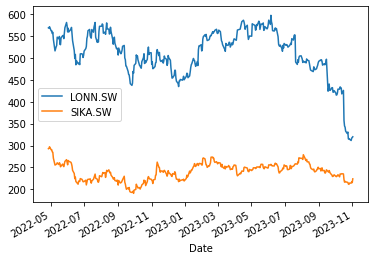

In [78]:
# Define the ticker list
import yfinance as yf
tickers_list = ['SIKA.SW', 'LONN.SW']

# Fetch the data
data = yf.download(tickers_list,'2022-04-27')['Adj Close']
data.plot()

In [79]:
data

,LONN.SW,SIKA.SW
Date,,
2022-04-27,569.189392,292.776306
2022-04-28,568.200867,293.368774
2022-04-29,571.759583,297.219788
2022-05-02,562.269714,290.307678
2022-05-03,562.665222,290.406433
...,...,...
2023-10-27,314.600006,214.100006
2023-10-30,311.500000,214.100006
2023-10-31,316.799988,216.899994


In [80]:
barriers = [329.76, 144.24]

In [81]:
print(data[data['LONN.SW'] <= barriers[0]]['LONN.SW'])
print(data[data['SIKA.SW'] <= barriers[1]]['SIKA.SW'])

Date
2023-10-23    327.600006
2023-10-25    315.000000
2023-10-26    315.899994
2023-10-27    314.600006
2023-10-30    311.500000
2023-10-31    316.799988
2023-11-01    318.600006
2023-11-02    320.000000
Name: LONN.SW, dtype: float64
Series([], Name: SIKA.SW, dtype: float64)


In [82]:
## specs
denomination = 1000.0
barrier = 0.6
coupon_rate = 0.08/4
coupon = coupon_rate*denomination

initial_fixing_date = datetime(2023,4,27)
final_fixing_date = datetime(2024,7,30)
maturity_date = datetime(2024,8,5)

issue_date = datetime(2023,4,28)

coupon_payment_dates = [
    datetime(2023,8,5),
    datetime(2023,11,5),
    datetime(2024,2,5),
    datetime(2024,5,5),
    datetime(2024,8,5),
]

early_redemption_dates = [
    datetime(2023,11,5),
    datetime(2024,2,5),
    datetime(2024,5,5),
]

early_redemption_level = stock_init_price = [549.60, 240.40]

converstion_ratios = [1.8195,4.1597]


In [83]:
from bisect import bisect_left

def BarrierReverseConvertible(params: typing.Dict, current_date: str, St: np.array):
    r = params.get('interest_rate')
    autocall_on = params.get('autocall')
    current_date = datetime.strptime(current_date, format)
    index = bisect_left(coupon_payment_dates, current_date)
    dates = coupon_payment_dates[index:]
    discounted_coupons = []
    for d in dates:
        discounted_c = coupon * np.exp(-r*((d - current_date).days))
        discounted_coupons.append(discounted_c)
    ## no early redemption ##
    V = (sum(discounted_coupons) + denomination*np.exp(-r*(maturity_date-current_date).days)*int(min(St[:,0])>barriers[0] and min(St[:,1])>barrier[1])
            + sum(discounted_coupons) + converstion_ratios[0]*min(St[:,0])*int(min(St[:,0])<=barrier[0])
            + sum(discounted_coupons) + converstion_ratios[0]*min(St[:,1])*int(min(St[:,1])<=barrier[1])
            + sum(discounted_coupons)*int(St[:,0][-1] == 0 or St[:,1][-1] == 0))
    if autocall_on:
        ## early redemption ##
        dates = sorted(list(set(dates) & set(early_redemption_dates)))
        mn = [min([St.loc[date.strftime(format)][0] for date in dates]), min([St.loc[date.strftime(format)][1] for date in dates])]
        V = ( V * (1 -int(mn[0] >= early_redemption_level[0] and mn[1] >= early_redemption_level[1])) 
            + (sum(discounted_coupons) + denomination*np.exp(-r*(maturity_date-current_date).days))*int(mn[0] >= early_redemption_level[0] and mn[1] >= early_redemption_level[1]) 
        )
    return V

In [43]:
log_returns = np.log(data) - np.log(data.shift(1))
mu = log_returns.mean().to_numpy()
mu = mu.reshape(2,1)
mu.shape

(2, 1)

In [42]:
cov = log_returns.cov()
cov.shape

(2, 2)

In [20]:
A = np.linalg.cholesky(log_returns.cov())
A.shape
A

array([[0.0230882 , 0.        ],
       [0.01187028, 0.01711018]])

In [41]:
diag = log_returns.cov().to_numpy().diagonal()
diag = diag.reshape(2,1)
diag.shape

(2, 1)

In [22]:
dt = 1
drift =(mu  - diag/2)*dt
drift

array([-0.00173169, -0.00087776])

In [45]:
dt = 252
Nsim = 1000
T = 10
S0 = 1000
St = np.exp(
       (mu  - diag/2)*dt
        + np.matmul(A, np.random.normal(0, np.sqrt(dt), size=(2, T)))
        )
print(St.shape)
St = np.vstack([np.ones(2), St.T])
St = S0 * St.cumprod(axis=0)
St

(2, 10)


array([[1000.        , 1000.        ],
       [ 495.93287021,  835.86150927],
       [ 542.16784103,  766.67162755],
       [ 351.24826552,  566.43444904],
       [ 363.2391399 ,  473.34710499],
       [ 509.98707516,  710.80906838],
       [ 380.86872822,  570.0860276 ],
       [ 313.90833394,  461.35986927],
       [ 148.8430407 ,  412.11682051],
       [  86.62758997,  269.96306235],
       [  41.04669539,  157.85388304]])

In [8]:
from model import SingleAssetGBM
params = {
    'name': 'LONN.SW',
    'maturity_date': '2024-08-05',
    'simulations': 1000,
    'window_size': 365,
    'prediction_range': ('2023-08-09', '2023-11-09'),
    'interest_rate_model': None, 
    'volatiliy_model': None,
    'variance_reduction': 'antithetic',
}

current_date = '2023-08-09'
lonn = SingleAssetGBM(params)
path = lonn.fit(current_date, data['LONN.SW']).generate_paths()
path.shape

(259, 1000)

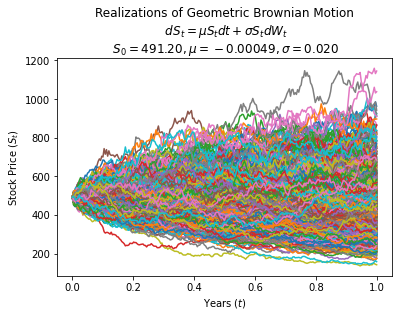

In [9]:
# Define time interval correctly
tt = np.full(shape=path.T.shape, fill_value=np.linspace(0,1,259)).T
plt.plot(tt, path)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    f"Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {lonn.S0:.2f}, \mu = {lonn.mu:.5f}, \sigma = {lonn.sigma:.3f}$"
)
plt.show()

In [35]:
format = '%Y-%m-%d'
def daterange(start_date: str, end_date: str):
    start_date = datetime.strptime(start_date, format)
    end_date =  datetime.strptime(end_date, format)
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

prediction_l = '2023-08-09'
prediction_r = '2023-11-10'

T = 1
M = 252
dt = T/M
for date in daterange(prediction_l, prediction_r):
    window_end = date.strftime(format)
    window_start = (date - timedelta(days=M)).strftime(format)
    # do modeling

In [18]:
product_price = convert_from_json_to_df('data/product/price.json')
product_price = product_price.set_index('date')
product_price['price'] = product_price['value'] / 100.0 * denomination

In [19]:
product_price

,value,price
date,,
2023-10-30,60.75,607.5
2023-10-27,61.30,613.0
2023-10-26,61.57,615.7
2023-10-25,61.54,615.4
2023-10-24,64.23,642.3
...,...,...
2023-05-05,98.82,988.2
2023-05-04,98.51,985.1
2023-05-03,98.09,980.9


In [46]:
data.loc[initial_fixing_date]

LONN.SW    546.273071
SIKA.SW    240.399994
Name: 2023-04-27 00:00:00, dtype: float64

### Interest rate model (Cox-Ingersoll-Ross Model)
- $dr_t = a (b - r_t) dt + \sigma \sqrt{r_t} dW_t$
- data from: https://www.investing.com/rates-bonds/switzerland-30-year-bond-yield-historical-data

In [31]:
import re
import os

dir = 'data/bond'
res = None
for file in os.listdir(dir):
    df = pd.read_csv(os.path.join(dir,file))[['Date','Price']]
    maturity_period = file.split(' ')[1]
    df.rename(columns={'Price': maturity_period},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
    df = df.set_index('Date')
    if res is None:
        res = df
    else:
        res = pd.concat([res, df], axis=1)

res
    

,4-Year,3-Month,1-Week,7-Year,10-Year,8-Year,2-Month,2-Year,1-Year,5-Year,6-Year,9-Year,3-Year,30-Year,1-Month,6-Month,20-Year
Date,,,,,,,,,,,,,,,,,
2022-01-01,NaN,-0.95,-1.00,NaN,NaN,NaN,-0.78,NaN,-0.80,NaN,NaN,NaN,NaN,NaN,-0.80,-0.90,NaN
2022-01-02,NaN,-0.90,-1.00,NaN,NaN,NaN,-0.76,NaN,-0.80,NaN,NaN,NaN,NaN,NaN,-0.77,-0.85,NaN
2022-01-03,-0.450,-0.86,-0.88,-0.276,-0.103,-0.195,-0.87,-0.700,-0.80,-0.382,-0.325,-0.148,-0.561,0.019,-0.84,-0.85,0.052
2022-01-04,-0.443,-0.86,-0.90,-0.265,-0.088,-0.186,-0.74,-0.729,-0.73,-0.380,-0.320,-0.138,-0.571,0.041,-0.86,-0.85,0.066
2022-01-05,-0.415,-0.87,-0.94,-0.226,-0.054,-0.164,-0.80,-0.715,-0.73,-0.351,-0.281,-0.105,-0.545,0.083,-0.87,-0.85,0.107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,1.098,1.71,1.53,1.064,1.154,1.106,1.54,1.265,1.83,1.086,1.055,1.160,1.139,1.156,1.66,1.76,1.203
2023-10-26,1.061,1.71,1.53,1.044,1.158,1.084,1.67,1.235,1.83,1.031,1.022,1.139,1.111,1.128,1.67,1.77,1.171
2023-10-27,1.013,1.56,1.53,1.013,1.082,0.987,1.65,1.183,1.71,0.977,0.973,1.076,1.054,1.130,1.50,1.60,1.136
